In [1]:
using Pkg
#Pkg.add("RigidBodyDynamics")
#Pkg.add("MeshCat")
#Pkg.add("MeshCatMechanisms")
#Pkg.add("StaticArrays")
#Pkg.add("Rotations")
#Pkg.add("ForwardDiff")
#Pkg.add("FiniteDiff")
#Pkg.add("Quaternions")
#Pkg.add("OSQP")
#Pkg.add("Plots")
#Pkg.add("Colors")
#Pkg.add("MathOptInterface")
#Pkg.add("Ipopt")
#Pkg.add("GeometryBasics")
#Pkg.add("CoordinateTransformations")
#Pkg.add("Optim")
include(joinpath(@__DIR__, "humanoid.jl"))
include(joinpath(@__DIR__, "ball_qp.jl"))
using LinearAlgebra
import ForwardDiff as FD
using GeometryBasics
#using Optim

WebIO._IJuliaInit()

## Finding Robot Balancing Pose

In [2]:
model = G1Humanoid()
mech = model.mech
# note: state is [q, dq], (q is in continous time, rad/s)
const x_guess = initial_state(model) # our guess state for balancing
mvis = initialize_visualizer(model) # visualizer 
set_configuration!(mvis, x_guess[1:state_dim(model)÷2])
foot_pos = get_right_foot_tip_location(mech, x_guess)
println("Foot tip position: ", foot_pos)

# Add red sphere at foot location
foot_point = mvis.visualizer["foot_point"]
setobject!(
    foot_point, 
    HyperSphere(Point3f(foot_pos), Float32(0.01))  # Both Float32
)
setprop!(foot_point, "color", RGB(1, 0, 0))  # Red color
render(mvis)

[ Info: Listening on: 127.0.0.1:8722, thread id: 1


Foot tip position: 

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8722


[-0.4539735038572158, -0.19194453008619367, 0.2135702686910089]


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("foot_point" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x66, 0x6f, 0x6f, 0x74, 0x5f, 0x70, 0x6f, 0x69, 0x6e, 0x74], nothing, Dict{String, Vector{UInt8}}("color" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x66, 0x6f, 0x6f, 0x74, 0x5f, 0x70, 0x6f, 0x69, 0x6e, 0x74]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "world" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("dummy1" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6c, 0x64, 0x2f, 0x64, 0x75, 0x6d, 0x6d, 0x79, 0x31], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("dummy2" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6d, 0x79, 0x31, 0x2f, 0x64, 0x75, 0x6d, 0x6d, 0x79, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("left_ankle_roll_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x72, 0x6f, 0x6c, 0x6c, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_ankle_roll_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6f, 0x6c, 0x6c, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_8" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x38], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x38], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "left_ankle_pitch_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x70, 0x69, 0x74, 0x63, 0x68, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_ankle_pitch_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x74, 0x63, 0x68, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_7" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x37], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x37], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "left_knee_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x6b, 0x6e, 0x65, 0x65, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_knee_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6b, 0x6e, 0x65, 0x65, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_6" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65,

In [3]:
function linesearch(z::Vector, Δz::Vector, merit_fx::Function;
                    max_ls_iters = 10)::Float64 # optional argument with a default

    α = 1
    for i = 1:max_ls_iters
        
        if (merit_fx(z + α * Δz) < merit_fx(z))
            return α
        end
        α = α / 2
        
    end
    error("linesearch failed")
end

function newtons_method(z0::Vector, res_fx::Function, res_jac_fx::Function, merit_fx::Function;
                        tol = 1e-10, max_iters = 50, verbose = false)::Vector{Vector{Float64}}
    
    # Computes Newton's method given the following inputs:
    # - z0, initial guess 
    # - res_fx, residual function 
    # - res_jac_fx, Jacobian of residual function wrt z 
    # - merit_fx, merit function for use in linesearch 
    
    # optional arguments 
    # - tol, tolerance for convergence. Return when norm(residual)<tol 
    # - max iter, max # of iterations 
    # - verbose, bool telling the function to output information at each iteration
    
    # return a vector of vectors containing the iterates 
    # the last vector in this vector of vectors should be the approx. solution 
    
    # return the history of guesses as a vector
    Z = [zeros(length(z0)) for i = 1:max_iters]
    Z[1] = z0 
    
    for i = 1:(max_iters - 1)        
        r = res_fx(Z[i]) 
        
        norm_r = norm(r) 
        if verbose 
            print("iter: $i    |r|: $norm_r   ")
        end
        
        # if converged, return Z[1:i]
        if norm_r < tol
            return Z[1:i]
        end
        
        Δz = -1 *  res_jac_fx(Z[i]) \ res_fx(Z[i])
        
        α = linesearch(Z[i], Δz, merit_fx)

        Z[i+1] = Z[i] .+ α*Δz

        if verbose
            print("α: $α \n")
        end
        
    end
    error("Newton's method did not converge")
end
function merit(z)
    # merit function
    r = kkt(z)
    return norm(r[1:94]) + 1e4*norm(r[95:end])
end

merit (generic function with 1 method)

In [5]:
# initial guess 
const x_guess = initial_state(model)

# indexing stuff 
const idx_x = 1:64
const idx_u = 65:93
const idx_c = 94:(157 + 3)

function cost(y::Vector)
    x = y[idx_x]
    u = y[idx_u]
    
    return 1/2 * (x - x_guess)' * (x - x_guess) + 1/2 * 1e-3*u'*u
end
function constraint(y::Vector)::Vector
    x = y[idx_x]
    u = y[idx_u]

    dynamics_constraint = dynamics(model, x, u)
    floot_flat_constraint = x[1:3]
    return [dynamics_constraint; floot_flat_constraint]
end
function kkt(z::Vector)::Vector
    x = z[idx_x]
    u = z[idx_u]
    λ = z[idx_c]
    
    y = [x;u]
    s = FD.gradient(cost, y) + FD.jacobian(constraint, y)' * λ
    
    pf = constraint(y)
    return [s; pf]
end

function kkt_jac(z::Vector)::Matrix
    x = z[idx_x]
    u = z[idx_u]
    λ = z[idx_c]
    
    y = [x;u]
    
    H = FD.hessian(cost, y)
    C = FD.jacobian(constraint, y)
    J = [
        H C';
        C zeros(size(λ, 1), size(λ, 1))
    ]

    β = 1e-3
    reg = [I(size(y, 1)) zeros(size(C')); zeros(size(C)) I(size(λ, 1))]

    return J + β * reg
    
end
   
    
z0 = [x_guess; zeros(29); zeros(67)]
Z = newtons_method(z0, kkt, kkt_jac, merit; tol = 1e-6, verbose = false, max_iters = 50)
# visualizer 
set_configuration!(mvis, Z[end][1:state_dim(model)÷2])
u_eq = Z[end][idx_u]
x_eq = Z[end][idx_x]
x_dot = dynamics(model, x_eq, u_eq)
@assert norm(x_dot, Inf) < 1e-6
foot_equilib_pos = get_right_foot_tip_location(mech, x_eq)
println(foot_equilib_pos)
println("Equilibrium found! $(norm(x_dot, Inf))")
render(mvis)

[-0.36974168511631605, -0.18129216838310608, 0.28428794901543925]
Equilibrium found! 6.824357431475766e-12


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("foot_point" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x66, 0x6f, 0x6f, 0x74, 0x5f, 0x70, 0x6f, 0x69, 0x6e, 0x74], nothing, Dict{String, Vector{UInt8}}("color" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x66, 0x6f, 0x6f, 0x74, 0x5f, 0x70, 0x6f, 0x69, 0x6e, 0x74]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "world" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("dummy1" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6c, 0x64, 0x2f, 0x64, 0x75, 0x6d, 0x6d, 0x79, 0x31], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("dummy2" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6d, 0x79, 0x31, 0x2f, 0x64, 0x75, 0x6d, 0x6d, 0x79, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("left_ankle_roll_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x72, 0x6f, 0x6c, 0x6c, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_ankle_roll_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6f, 0x6c, 0x6c, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_8" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x38], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x38], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "left_ankle_pitch_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x70, 0x69, 0x74, 0x63, 0x68, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_ankle_pitch_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x74, 0x63, 0x68, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_7" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x37], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x37], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "left_knee_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x6b, 0x6e, 0x65, 0x65, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_knee_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6b, 0x6e, 0x65, 0x65, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_6" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65,

In [6]:
x_max = norm(x_eq, Inf)
u_max = norm(u_eq, Inf)
println(x_max)
println(u_max)
save("equilibrium.jld2", "x", x_eq, "u", u_eq)

1.4157584329238388


13.891208669154103


# IHLQR

In [7]:
dt = 0.03
function rk4(model, x, u, dt)
    k1 = dt * dynamics(model, x, u)
    k2 = dt * dynamics(model, x .+ k1/2, u)
    k3 = dt * dynamics(model, x .+ k2/2, u)
    k4 = dt * dynamics(model, x .+ k3, u)
    return x + (1/6) * (k1 + 2*k2 + 2*k3 + k4)
end

function ihlqr(A::Matrix,B::Matrix,Q::Matrix,R::Matrix; max_iter = 10000,tol = 1e-5)::Tuple{Matrix, Matrix} 
    nx, nu = size(B)
    P = deepcopy(Q)
    for riccati_iter = 1:max_iter 
        K = (R + B'*P*B)\(B'*P*A)
        P_next = Q + A'*P*(A - B * K)
        if norm(P_next - P) <= tol
            return P_next, K
        end
        P = P_next
    end
    error("ihlqr did not converge")
end

A = FD.jacobian(x_ -> rk4(model, x_, u_eq, dt), x_eq)
B = FD.jacobian(u_ -> rk4(model, x_eq, u_, dt), u_eq)

Q = diagm(vcat(zeros(3) , 1e0*ones(29), zeros(3), 1e0*ones(29))) # floating base not controllable, so zero out associated cost
R = diagm(1e-3*ones(length(u_eq)))
_,K = ihlqr(A, B, Q, R);

## Ball Dynamics, Calculating Kick Point

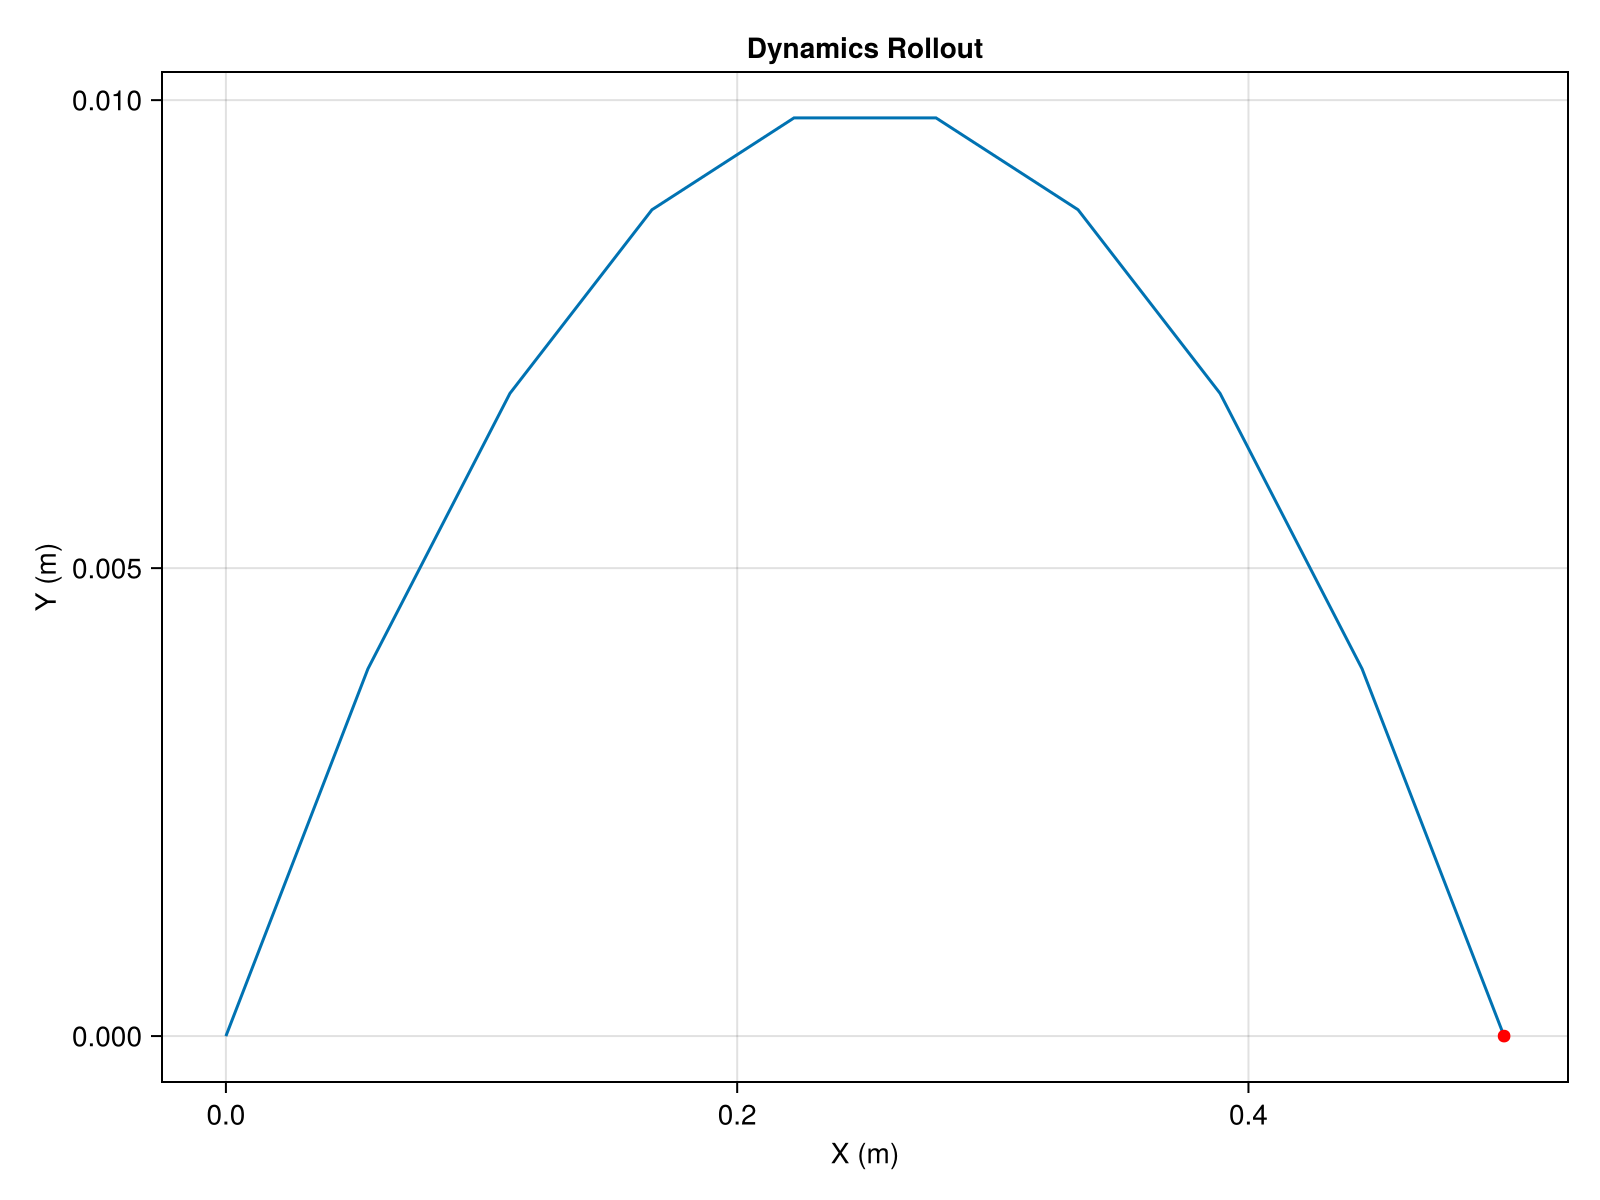

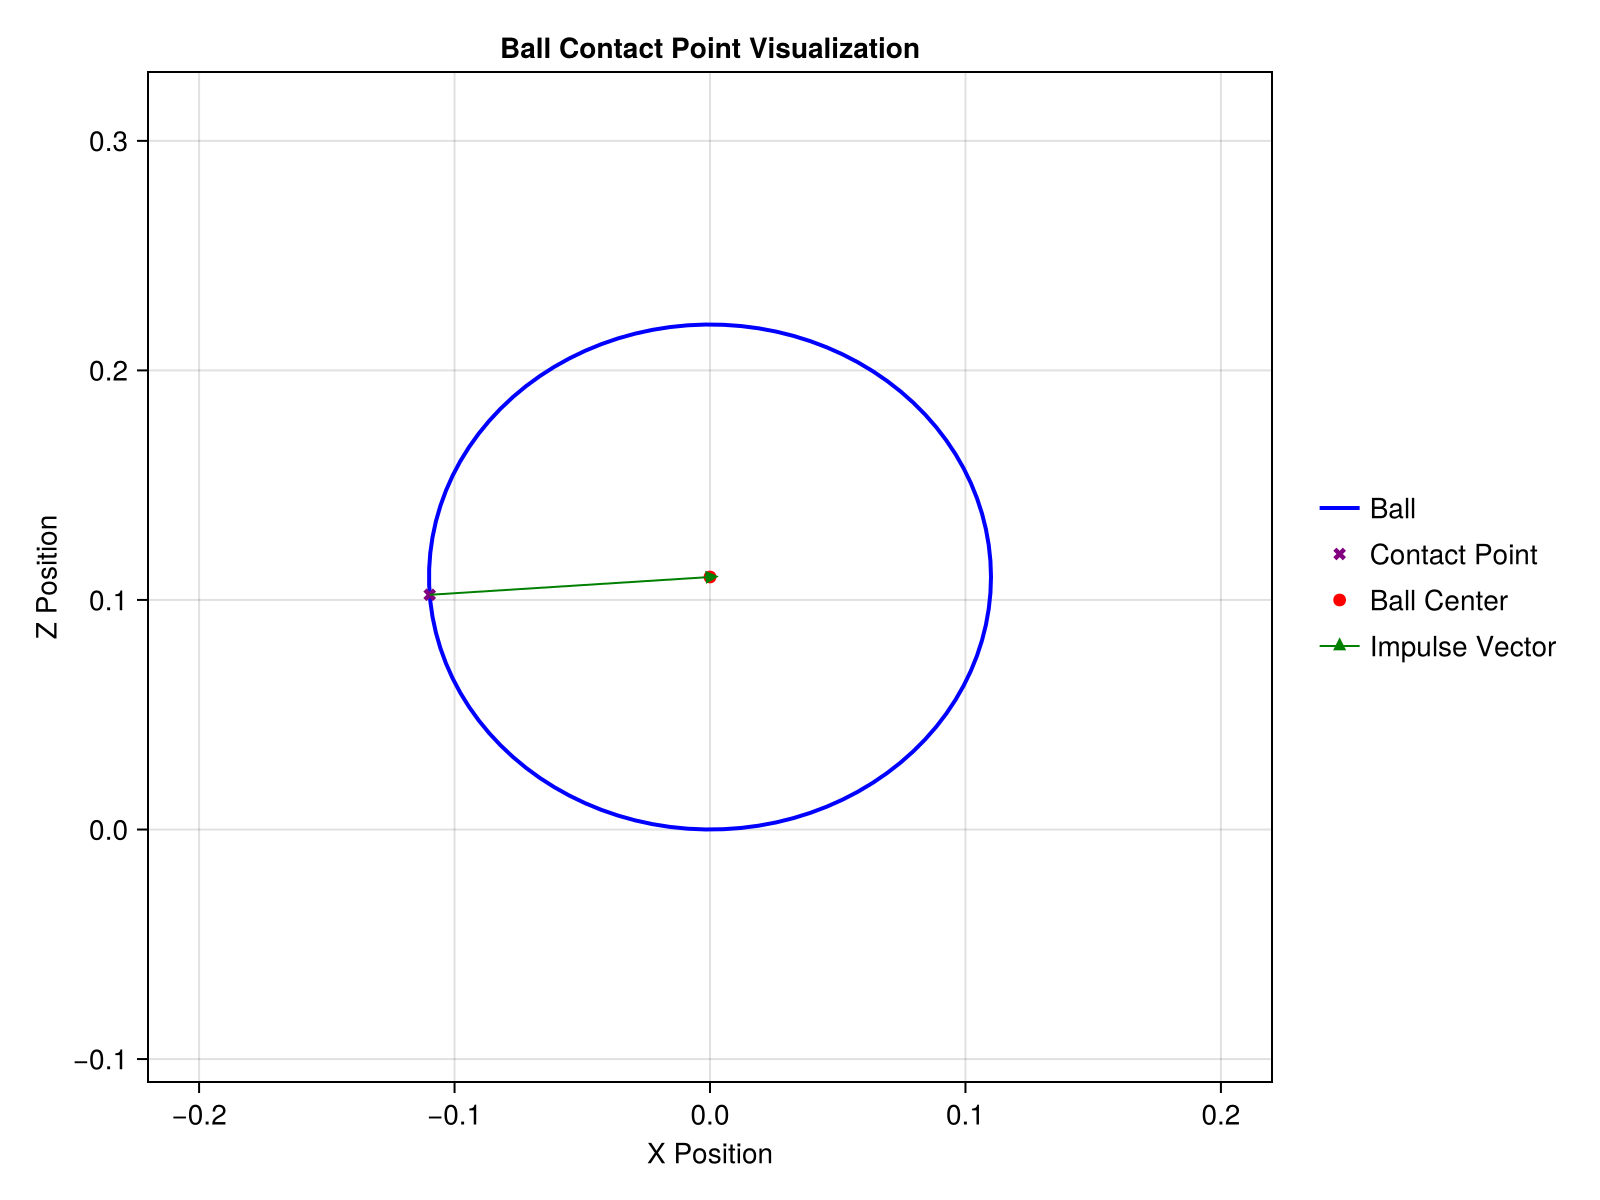

[0.09027336595017596, -0.13, 0.10224978838379283]
[5.555555570834638, 0.0, 0.3924000010791924]

In [8]:
q_i = [0.0, 0.0] # Note, this is in the X-Z Plane only, y value will be assigned manually after the fact
q_des = [0.5, 0.0]
J_max = Inf
ball_flight_steps = 10
m = 0.1
dt=0.01
J = optimize_impulse(q_des, q_i, N=ball_flight_steps, J_max=J_max, dt=dt, m=m) # Can also specify mass
dynamics_rollout(J, q_des, q_i, N=ball_flight_steps, dt=dt, m=m)
p_c = get_contact_point(J) # Can also specify radius of ball
visualize_contact(J, p_c)
p_c = [p_c[1] + 0.2, -0.13, p_c[2]] # accounting for ball being placed forward
println(p_c)
v_des = J / m
v_des = [v_des[1], 0, v_des[2]]
print(v_des)

## Solve For Initial Guess

In [9]:
function generate_kick_arc_trajectory(
    start_pos::Vector{Float64},
    end_pos::Vector{Float64},
    arc_dip::Float64,
    arc_rise::Float64,
    max_step_norm::Float64;
    max_points::Int = 500,
    scale_dip_if_needed::Bool = true
)
    num_points = 2
    orig_dip = arc_dip  # Save original for scaling logic

    function create_kick_arc(n, dip)
        arc_traj = Vector{SVector{3, Float64}}()
        for i in range(0, 1, length=n)
            pos = (1 - i) * start_pos .+ i * end_pos

            if i < 0.5
                z_mod = -4 * dip * i * (1 - i)
            else
                z_mod = 2 * arc_rise * (i - 0.5)^2
            end

            pos[3] += z_mod
            push!(arc_traj, SVector{3}(pos))
        end
        return arc_traj
    end

    while num_points <= max_points
        arc = create_kick_arc(num_points, arc_dip)
        max_dist = maximum(norm(arc[i+1] - arc[i]) for i in 1:length(arc)-1)

        if max_dist < max_step_norm
            return arc
        end

        # Optional: adaptive dip scaling
        if scale_dip_if_needed && num_points == max_points
            arc_dip *= 0.95  # reduce dip a bit
            num_points = 2   # restart with fewer points
            #@info "Reducing dip to $(round(arc_dip, digits=4)) to meet step constraint."
        else
            num_points += 1
        end
    end

    error("Could not satisfy step constraint after $max_points points. Final dip = $(round(arc_dip, digits=4))")
end




# Example inputs
equilib_foot_pos = [-0.3697416851162835, -0.1812921683831133, 0.28428794901541954]
goal_foot_pos = p_c

kick_arc = generate_kick_arc_trajectory(
    equilib_foot_pos, 
    goal_foot_pos, 
    0.04,   
    0.01,
    0.03
)

if kick_arc[size(kick_arc, 1)] != goal_foot_pos
    push!(kick_arc, goal_foot_pos)
end

if kick_arc[1] == equilib_foot_pos
    popfirst!(kick_arc)
end
# Print the resulting arc
for pos in kick_arc
    println(pos)
end

[-0.3520487985368043, -0.17931939267607047, 0.27270789586982447]
[-0.3343559119573251, -0.17734661696902768, 0.2614941295585489]
[-0.31666302537784585, -0.17537384126198485, 0.2506466500815928]
[-0.2989701387983667, -0.173401065554942, 0.24016545743895626]
[-0.28127725221888744, -0.1714282898478992, 0.23005055163063926]
[-0.26358436563940824, -0.16945551414085636, 0.22030193265664177]
[-0.24589147905992906, -0.1674827384338136, 0.21091960051696385]
[-0.22819859248044982, -0.16550996272677074, 0.2019035552116054]
[-0.21050570590097065, -0.16353718701972791, 0.1932537967405665]
[-0.1928128193214914, -0.16156441131268512, 0.18497032510384714]
[-0.1751199327420122, -0.15959163560564227, 0.17705314030144728]
[-0.157427046162533, -0.15761885989859947, 0.16950224233336697]
[-0.1397341595830538, -0.15564608419155665, 0.1932688686996062]
[-0.12204127300357458, -0.15367330848451383, 0.18629698678182172]
[-0.10434838642409537, -0.15170053277747103, 0.1793842764616704]
[-0.08665549984461612, -0.14

In [29]:
x_curr = x_eq
states = Vector{Vector{Float64}}(undef, length(kick_arc)+1)
states[1] = x_eq
inputs = Vector{Vector{Float64}}(undef, length(kick_arc)+1)
inputs[1] = u_eq
k = 2
for desired_foot_pos in kick_arc
    # indexing stuff 
    idx_x = 1:64
    idx_u = 65:93
    idx_c = 94:(157 + 3 + 3)
    function cost(y::Vector)
        x = y[idx_x]
        u = y[idx_u]
        
        return 1/2 * (x - x_curr)' * (x - x_curr) + 1/2 * 1e-3*u'*u
    end
    function constraint(y::Vector)::Vector
        x = y[idx_x]
        u = y[idx_u]

        dynamics_constraint = dynamics(model, x, u)
        floot_flat_constraint = x[1:3]
        kick_constraint = get_right_foot_tip_location(model.mech, x) - desired_foot_pos
        return [dynamics_constraint; floot_flat_constraint; kick_constraint]
    end
    function kkt(z::Vector)::Vector
        x = z[idx_x]
        u = z[idx_u]
        λ = z[idx_c]
        
        y = [x;u]
        s = FD.gradient(cost, y) + FD.jacobian(constraint, y)' * λ
        
        pf = constraint(y)
        return [s; pf]
    end

    function kkt_jac(z::Vector)::Matrix
        x = z[idx_x]
        u = z[idx_u]
        λ = z[idx_c]
        
        y = [x;u]
        
        H = FD.hessian(cost, y)
        C = FD.jacobian(constraint, y)
        J = [
            H C';
            C zeros(size(λ, 1), size(λ, 1))
        ]

        β = 1e-3
        reg = [I(size(y, 1)) zeros(size(C')); zeros(size(C)) I(size(λ, 1))]

        return J + β * reg
        
    end
    println("Solving timestep $(k), with foot position: $(desired_foot_pos)")
    z0 = [x_curr; zeros(29); zeros(70)]
    Z = newtons_method(z0, kkt, kkt_jac, merit; tol = 1e-3, verbose = false, max_iters = 1000)
    u = Z[end][idx_u]
    inputs[k] = u
    x_curr = Z[end][idx_x]
    states[k] = x_curr
    k += 1
end


Solving timestep 2, with foot position: [-0.3520487985368043, -0.17931939267607047, 0.27270789586982447]
Solving timestep 3, with foot position: [-0.3343559119573251, -0.17734661696902768, 0.2614941295585489]
Solving timestep 4, with foot position: [-0.31666302537784585, -0.17537384126198485, 0.2506466500815928]
Solving timestep 5, with foot position: [-0.2989701387983667, -0.173401065554942, 0.24016545743895626]
Solving timestep 6, with foot position: [-0.28127725221888744, -0.1714282898478992, 0.23005055163063926]
Solving timestep 7, with foot position: [-0.26358436563940824, -0.16945551414085636, 0.22030193265664177]
Solving timestep 8, with foot position: [-0.24589147905992906, -0.1674827384338136, 0.21091960051696385]
Solving timestep 9, with foot position: [-0.22819859248044982, -0.16550996272677074, 0.2019035552116054]
Solving timestep 10, with foot position: [-0.21050570590097065, -0.16353718701972791, 0.1932537967405665]
Solving timestep 11, with foot position: [-0.19281281932

In [11]:
mvis = initialize_visualizer(model) # visualizer
open(mvis)
dt = 0.02
for k = 1:length(states)
    q = states[k]
    v = zeros(length(q))              # zero velocities
    full_state = [q; v]               # concatenate position and velocity
    set_configuration!(mvis, full_state[1:state_dim(model)÷2])
    sleep(dt*5)
    render(mvis)
end

[ Info: Listening on: 127.0.0.1:8723, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8723


In [30]:
x_g = states[end]
u_g = inputs[end]
for k = 1:length(kick_arc)-1
    states[k][33:64] = (states[k+1][1:32] - states[k][1:32]) / dt
end

nv = 32

window_size = 3
states[end][33:64] = states[end-1][33:64]
for i in 1:length(kick_arc)
    count = 0
    for j in max(1, i - window_size):min(length(kick_arc), i + window_size)
        states[i][33:64] .+= states[j][33:64]
        count += 1
    end
    states[i][33:64] ./= count
end
save("guess.jld2", "x", states, "x_g", x_g, "u_g", u_g)

## Calculating Kick Trajectory

In [13]:
using Pkg

#Pkg.add("NamedTrajectories")
#Pkg.add("CairoMakie")
#Pkg.add("BenchmarkTools")
#Pkg.add(url="https://github.com/kevin-tracy/lazy_nlp_qd.jl.git")
#Pkg.add("ProgressMeter")
using NamedTrajectories
using CairoMakie
using BenchmarkTools
import ForwardDiff as FD
using LinearAlgebra
using Plots
using lazy_nlp_qd
#import MeshCat as mc
using StaticArrays
using ProgressMeter
using FileIO
using Optim
include(joinpath(@__DIR__, "../src/utils/utils.jl"))
include(joinpath(@__DIR__, "../src/utils/nlp_utils.jl"))

constraint_violation (generic function with 1 method)

In [14]:
function hermite_simpson(params::NamedTuple, x1::Vector, x2::Vector, u)::Vector
    model = params.model
    dt = params.dt
    x1dot = dynamics(model, x1, u)
    x2dot = dynamics(model, x2, u)
    x_k12 = 1/2 * (x1 + x2) + dt/8 * (x1dot - x2dot)
    return x1 + dt/6 * (x1dot + 4 * dynamics(model, x_k12, u) + x2dot) - x2
end

hermite_simpson (generic function with 1 method)

In [15]:
function quadratic_cost(traj_indices::NamedTuple, k::Int64, Q::Matrix{Float64}, R::Matrix{Float64}, x_g)
    xi, ui = traj_indices.x[k], traj_indices.u[k]
    # TODO: Tune this cost function -> add costs related to foot position
    function cost_func(params::NamedTuple, z::Vector)
        x = z[xi]
        #foot_tip_pos = get_right_foot_tip_location(params.model.mech, x)
        # 0.5*(x - x_g)'*Q2*(x-x_g)
        #foot_pos_cost = 0
        # if (foot_tip_pos[2]) > 0
        #     foot_pos_cost = 1000
        # end
        return 0.5*(x[1:32] - x_g[1:32])'*Q*(x[1:32] - x_g[1:32]) + 0.5 * z[ui]'*R*z[ui] #+ foot_pos_cost

    end
    function cost_grad!(params::NamedTuple, z::Vector{Float64}, grad::Vector{Float64})
        grad .+= FD.gradient(z_ -> cost_func(params, z_), z)
    end
    return (cost_func=cost_func, cost_grad=cost_grad!)
end

function final_cost(traj_indices::NamedTuple, N::Int64, Qf::Matrix{Float64}, x_g)
    xi = traj_indices.x[N]
    # TODO: Tune this cost function
    cost_func(params::NamedTuple, z::Vector) = 0.5*((z[xi][1:32] - x_g[1:32])'*Qf*(z[xi][1:32] - x_g[1:32]))
    # cost_func(params::NamedTuple, z::Vector) = 0.5*((z[xi] - x_g)'*Qf*(z[xi] - x_g))

    function cost_grad!(params::NamedTuple, z::Vector{Float64}, grad::Vector{Float64})
        grad .+= FD.gradient(z_ -> cost_func(params, z_), z)
    end
    return (cost_func=cost_func, cost_grad=cost_grad!)
end

# Dynamics Constraints
function dyn_constraint(traj_indices::NamedTuple, k::Int64)
    # Get indices for knot data in trajectory
    xi, ui, next_xi = traj_indices.x[k], traj_indices.u[k], traj_indices.x[k+1]
    nx = 64
    residual(params::NamedTuple, z::Vector, con::AbstractVector) = con .= hermite_simpson(params, z[xi], z[next_xi], z[ui])
    
    function jacobian!(params::NamedTuple, z::Vector, conjac::AbstractMatrix)
        x_k, u_k, next_x_k = z[xi], z[ui], z[next_xi]
        conjac[:, xi] = FD.jacobian(x_ -> hermite_simpson(params, x_, next_x_k, u_k), x_k);
        conjac[:, ui] = FD.jacobian(u_ -> hermite_simpson(params, x_k, next_x_k, u_), u_k);
        conjac[:, next_xi] = FD.jacobian(x_ -> hermite_simpson(params, x_k, x_, u_k), next_x_k);
        return nothing
    end

    # Indication of which blocks are populated (i.e. sparsity structure) for constraint
    function sparsity!(conjac::AbstractMatrix)
        conjac[:, xi] .= 1;
        conjac[:, ui] .= 1;
        conjac[:, next_xi] .= 1;
        return nothing
    end
    bounds = (zeros(nx), zeros(nx))
    return (length=nx, residual=residual, jacobian=jacobian!, sparsity=sparsity!, bounds=bounds)
end

# State Intial Condition Constraint
function ic_constraint(traj_indices::NamedTuple, x_ic::Vector{Float64})
    x0 = traj_indices.x[1]
    nx = 64
    residual(params::NamedTuple, z::Vector, con::AbstractVector) = con .= z[x0] - x_ic
    jacobian!(params::NamedTuple, z::Vector, conjac::AbstractMatrix) = conjac[:, x0] = I(length(x_ic))
    sparsity!(conjac::AbstractMatrix) = conjac[:, x0] .= 1
    bounds = (zeros(nx), zeros(nx))
    return (length=nx, residual=residual, jacobian=jacobian!, sparsity=sparsity!, bounds=bounds)
end

# State Goal Condition Constraint
function goal_constraint(traj_indices::NamedTuple, x_g::Vector{Float64}, N)
    x_N = traj_indices.x[N]
    nx = 64
    nq = 32
    residual(params::NamedTuple, z::Vector, con::AbstractVector) = con .= z[x_N][1:32] - x_g[1:32]
    # residual(params::NamedTuple, z::Vector, con::AbstractVector) = con .= z[x_N] - x_g

    jacobian!(params::NamedTuple, z::Vector, conjac::AbstractMatrix) = conjac[:, x_N[1:32]] = I(length(x_N[1:32]))
    # jacobian!(params::NamedTuple, z::Vector, conjac::AbstractMatrix) = conjac[:, x_N] = I(length(x_N))

    sparsity!(conjac::AbstractMatrix) = conjac[:, x_N[1:32]] .= 1
    # sparsity!(conjac::AbstractMatrix) = conjac[:, x_N] .= 1

    bounds = (zeros(nq), zeros(nq))
    # bounds = (zeros(nx), zeros(nx))

    return (length=nq, residual=residual, jacobian=jacobian!, sparsity=sparsity!, bounds=bounds)
end

function foot_velocity_constraint(traj_indices::NamedTuple, mech::Mechanism, v_des, N)
    xi = traj_indices.x[N]
    foot_body = findbody(model.mech, "right_ankle_roll_link")
    world_body = findbody(model.mech, "world")
    kinematic_path = path(model.mech, foot_body, world_body)

    residual(params::NamedTuple, z::Vector, con::AbstractVector) = begin
        #state = MechanismState(params.model.mech)
        #copyto!(state, z[xi])
        #Jg = geometric_jacobian(state, kinematic_path) # geometric jacobian tells you how each joint will effect angular and translational velocity
        # analytical jacobian is similar, but helps you find the change in your chosen parameter mapping
        #J = Matrix(Jg)[1:3, :]
        # J(q) * dq = v
        J = FD.jacobian(x_ -> get_right_foot_tip_location(model.mech, x_), z[xi])
        dq = z[xi[33:64]]
        con .= J[:, 1:32]*dq - v_des
        #println("Y-residual: ", con[2])
    end

   jacobian!(params::NamedTuple, z::Vector, conjac::AbstractMatrix) = begin
        #state = MechanismState(params.model.mech)
        #copyto!(state, z[xi])
        #Jg = geometric_jacobian(state, kinematic_path)
        # Approximate hessian with jacobian, instead of finding jacobian of J * dq
        #J = Matrix(Jg)[1:3, :]
        J = FD.jacobian(x_ -> get_right_foot_tip_location(model.mech, x_), z[xi])
        conjac[:, xi[33:64]] .= J[:, 1:32]
    end
    
    
    sparsity!(conjac::AbstractMatrix) = conjac[:, xi] .= 1
    bounds = (zeros(3), zeros(3))
    
    return (length=3, residual=residual, jacobian=jacobian!, sparsity=sparsity!, bounds=bounds)
end

foot_velocity_constraint (generic function with 1 method)

In [16]:
function optimize_trajectory_sparse(nx, nu, dt, N, x_eq, u_eq, equilib_foot_pos, kick_foot_pos, model, lower_joint_limits, upper_joint_limits, x_guess, u_guess, x_g, v_g)
    nq = 32
    Q = diagm(1e-1*ones(nq)) # only care about position, not velocity
    R = diagm(1e-3*ones(nu))
    Qf = diagm(1e3*ones(nq))
    x_ic = 1 * x_eq
    x_ic[1:3] .= 0
    x_g[1:3] .= 0
    components = (
        x = rand(nx, N),
        u = rand(nu, N),
    )

    z0 = vcat(
        [vcat(x_guess[i], u_guess[i]) for i in 1:N]...
    )

    traj = NamedTrajectory(components; timestep=dt, controls=:u)
    traj_indices = NamedTuple{traj.names}([[(k - 1)*traj.dim .+ getproperty(traj.components, symbol) for k in 1:traj.T] for symbol in traj.names])
    cost_objs = vcat(
        [quadratic_cost(traj_indices, k, Q, R, x_g) for k = 1:N-1], 
        final_cost(traj_indices, N, Qf, x_g)
    )

    # TODO: expirement with constraints to limit the wiggle of the foot
    con_objs = Vector{NamedTuple}([foot_velocity_constraint(traj_indices, model.mech, v_g, N), ic_constraint(traj_indices, x_ic), goal_constraint(traj_indices, x_g, N), [dyn_constraint(traj_indices, k) for k = 1:N-1]...])
    nc, conjac = setup_constraints(traj, con_objs)

    param = (costs = cost_objs, constraints = con_objs, nconstraints=nc, nz=length(traj.datavec), model=model, dt=dt)
    @assert nc < length(traj.datavec)
    # Constrain bounds (equality and inequality)
    c_l, c_u = constraint_bounds(param)


    # primal bounds TODO: tighten these to get desired behaviour
    z_l, z_u = fill(-120.0, param.nz), fill(120.0, param.nz)

    # bound foot rotation to be zero
    for k = 1:N
        xi = traj_indices.x[k]
        ui = traj_indices.u[k]
        z_l[xi[1:3]] .= 0
        z_u[xi[1:3]] .= 0
        z_l[xi[4:32]] .= 5 .* lower_joint_limits # TODO: these joint limits seem to be the limiting constraints
        z_u[xi[4:32]] .= 2 .* upper_joint_limits
        z_l[xi[36:64]] .= -15
        z_u[xi[36:64]] .= 15
        z_l[xi[33:35]] .= 0
        z_u[xi[33:35]] .= 0
    end

    z = lazy_nlp_qd.sparse_fmincon(cost_func,
                                cost_gradient!,
                                constraint_residual!,
                                constraint_jacobian!,
                                conjac,
                                z_l,
                                z_u, 
                                c_l,
                                c_u,
                                z0,
                                param,
                                tol = 1e-3, # for testing purposes
                                c_tol = 1e-6, # for testing purposes
                                max_iters = 15000,
                                print_level = 5); # for testing purposes
    traj.datavec .= z
    save("trajectory.jld2", "traj", traj, "traj_indices", traj_indices)

    return traj
end

optimize_trajectory_sparse (generic function with 1 method)

In [17]:
equilib_loaded = load("equilibrium.jld2")
x_eq = equilib_loaded["x"]
u_eq = equilib_loaded["u"]
guess_loaded = load("guess.jld2")
x_init = guess_loaded["x"]
lower_limits = [
    -2.5307, -0.5236, -2.7576, -0.087267, -0.87267, -0.2618,
    -2.5307, -2.9671, -2.7576, -0.087267, -0.87267, -0.2618,
    -2.618, -0.52, -0.52,
    -3.0892, -1.5882, -2.618, -1.0472, -1.9722, -1.6144, -1.6144,
    -3.0892, -2.2515, -2.618, -1.0472, -1.9722, -1.6144, -1.6144
]

upper_limits = [
     2.8798,  2.9671,  2.7576,  2.8798,  0.5236,  0.2618,
     2.8798,  0.5236,  2.7576,  2.8798,  0.5236,  0.2618,
     2.618,  0.52,  0.52,
     2.6704,  2.2515,  2.618,  2.0944,  1.9722,  1.6144, 1.6144,
     2.6704,  1.5882,  2.618,  2.0944,  1.9722,  1.6144, 1.6144
];

In [18]:
model = G1Humanoid()
mech = model.mech
nx, nu, dt, N = size(x_eq, 1), size(u_eq, 1), 0.02, length(x_init)

equilib_foot_pos = [-0.3697416851162835, -0.1812921683831133, 0.28428794901541954]
goal_foot_pos = p_c
u_init = [0.05 * rand(nu) for k=1:length(x_init)]
x_g = x_init[end]
v_g = v_des

traj = optimize_trajectory_sparse(nx, nu, dt, N, x_eq, u_eq, equilib_foot_pos, goal_foot_pos, model, lower_limits, upper_limits, x_init, u_init, x_g, v_g);


-----------------checking dimensions of everything-------------

-----------------checking primal bounds------------------------

-----------------IPOPT beginning solve-------------------------


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:   255374
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     2436
                     variables with only lower bounds:        0
                variables

# Visualizing Results
### Assumption Mfoot >> Mball

In [31]:
loaded = load("trajectory.jld2")
traj = loaded["traj"]
traj_indices = loaded["traj_indices"];

equilib_loaded = load("equilibrium.jld2")
x_eq = equilib_loaded["x"]
u_eq = equilib_loaded["u"]
guess_loaded = load("guess.jld2")
x_g = guess_loaded["x_g"]
u_g = guess_loaded["u_g"]
model = G1Humanoid();

In [32]:
# rk4 keeps blowing up, trying hermite simpson instead
function hermite_simpson_step(model::G1Humanoid, x::Vector, u::Vector, dt::Real)
    x_guess = rk4(model, x, u, dt)
    params = (model=model, dt=dt)
    obj(xn) = begin
        res = hermite_simpson(params, x, xn, u)
        return sum(abs2, res)
    end

    result = optimize(obj, x_guess, BFGS(); autodiff = :forward)
    x_next = Optim.minimizer(result)
    res = hermite_simpson((model=model, dt=dt), x, x_next, u)
    return x_next
end

function rk4(model::G1Humanoid, x::Vector, u::Vector, dt::Real)::Vector
    #x[1:3] .= 0 # the base cannot move
    k1 = dt * dynamics(model, x, u)
    k2 = dt * dynamics(model, x + 0.5 * k1, u)
    k3 = dt * dynamics(model, x + 0.5 * k2, u)
    k4 = dt * dynamics(model, x + k3, u)
    xp1 = x + (1/6) * (k1 + 2*k2 + 2*k3 + k4)

    #xp1[33:end] = clamp.(xp1[33:end], -15, 15) # clamp velocity, as it was blowing up before
    return xp1 #x + (1/6) * (k1 + 2*k2 + 2*k3 + k4)
end

function ball_dynamics(x, dt) # rk4 for the ball
    function dyn(x)
        g = [0; 0; 9.81]
        q = x[1:3]
        v = x[4:6]
        dq = v
        dv = -g
        return [dq; dv]
    end
    k1 = dt * dyn(x)
    k2 = dt * dyn(x + 0.5 * k1)
    k3 = dt * dyn(x + 0.5 * k2)
    k4 = dt * dyn(x + k3)
    return x + (1/6) * (k1 + 2*k2 + 2*k3 + k4)
end


function animate_humanoid_kick(Xh, Xb, model, dt)
    # Initialize visualizer pair correctly
    mvis = initialize_visualizer(model)  # This should return both mvis AND vis
    vis = mvis.visualizer  # Extract from initialized visualizer
    open(mvis)
    # Use mvis's visualizer for all objects
    setobject!(vis["ball"], 
        GeometryBasics.HyperSphere{3, Float32}(Point3f(0,0,0), 0.11),
        MeshPhongMaterial(color=RGBA(1,0,0,1)))
    
    fps = floor(Int, 1/dt)
    anim = MeshCat.Animation(vis, fps=fps)

    for k in 1:length(Xh)
        atframe(anim, k) do
            set_configuration!(mvis, Xh[k][1:32])
            
            settransform!(vis["ball"], Translation(SVector{3}(Xb[k][1:3])))

        end
    end

    setanimation!(vis, anim)
    return render(vis)
end


animate_humanoid_kick (generic function with 1 method)

In [33]:
dt = 0.02
A = FD.jacobian(x_ -> rk4(model, x_, u_eq, dt), x_eq)
B = FD.jacobian(u_ -> rk4(model, x_eq, u_, dt), u_eq)

Q = diagm(vcat(zeros(3) , 1e0*ones(29), zeros(3), 1e0*ones(29))) # floating base not controllable, so zero out associated cost
R = diagm(1e-3*ones(length(u_eq)))
_,Keq = ihlqr(A, B, Q, R);

A = FD.jacobian(x_ -> rk4(model, x_, u_g, dt), x_g)
B = FD.jacobian(u_ -> rk4(model, x_g, u_, dt), u_g)

R = diagm(1e-3*ones(length(u_eq)))
_,Kg = ihlqr(A, B, Q, R);

In [ ]:
# Generate actual ball and humanoid trajectories
model = G1Humanoid();
dt = 0.02
N = length(traj_indices.x)
z = traj.datavec
nx = length(z[traj_indices.x[1]])
nu = length(z[traj_indices.u[1]])
balance_time = 5 # TODO, do some balancing before executing the kick trajectory, and after the kick is complete
ball_flight_steps = 5 #ball_flight_steps
tot_time = balance_time + N + ball_flight_steps
nuh = length(u_eq) # humanoid input and states
nxh = length(x_eq)
nxb = 6 # ball state
Uh = [zeros(nu) for _ in 1:tot_time-1]
Xh = [zeros(nx) for _ in 1:tot_time]
Xb = [zeros(nxb) for _ in 1:tot_time] # 
Uh[1] = u_eq
Xh[1] = x_eq
Xb[1] = [0.2, -0.13, 0.11, 0, 0, 0] # position of center of ball


# TODO: get K's from Daksh for LQR
for k = 1:tot_time - 1
    if k <= balance_time
        Xb[k+1] = 1 * Xb[k] 
        Uh[k] = u_eq - Keq * (Xh[k] - x_eq)
        Xh[k+1] = hermite_simpson_step(model, 1* Xh[k], 1 * Uh[k], dt) #.+ 1e-5 * rand(nx)
    elseif k <= balance_time + N - 1
        #println(maximum(Xh[k] .- z[traj_indices.x[k-balance_time]]))
        Xb[k+1] = 1 * Xb[k]
        Uh[k] = 1 * z[traj_indices.u[k - balance_time]] #- K * (Xh[k] - z[traj_indices.x[k - balance_time]])
        Xh[k+1] = hermite_simpson_step(model, 1 * Xh[k], Uh[k], dt)
    elseif k == balance_time + N
        Uh[k] = 1 * u_eq #- K * (Xh[k] - x_eq)
        Xh[k+1] = hermite_simpson_step(model, 1 * Xh[k], Uh[k], dt)
        #println(Xh[k+1])
        #foot_body = findbody(model.mech, "right_ankle_roll_link")
        #world_body = findbody(model.mech, "world")
        #kinematic_path = path(model.mech, foot_body, world_body)
        #state = MechanismState(model.mech)
        #copyto!(state, z[traj_indices.x[k]])        
        #right_ankle_to_world = relative_transform(state, default_frame(world_body), default_frame(foot_body))
        #println(RigidBodyDynamics.rotation(right_ankle_to_world))
        #R = (RigidBodyDynamics.rotation(right_ankle_to_world))
        #Jg = geometric_jacobian(state, kinematic_path)
        #J = Matrix(Jg)[1:3, :]
        #dq = 1 * z[traj_indices.x[k][33:64]]
        #println(dq)
        J = FD.jacobian(x_ -> get_right_foot_tip_location(model.mech, x_), z[traj_indices.x[k-balance_time]])
        #println(size(J))
        dq = 1 * z[traj_indices.x[k - balance_time][33:64]]
        println(J[:, 1:32]*dq)
        Xb[k][4:6] .= J[:, 1:32]*dq
        Xb[k+1] .= ball_dynamics(Xb[k], dt)
    else
        Uh[k] = u_g #- Kg * (Xh[k] - x_g)
        Xh[k+1] = hermite_simpson_step(model, 1*Xh[k], 1*Uh[k], dt)
        Xb[k+1] = ball_dynamics(Xb[k], dt)
    end
end

[5.555555570834605, -8.065770273901762e-14, 0.3924000010800805]


LoadError: ArgumentError: matrix contains Infs or NaNs

In [27]:
using MeshCatMechanisms 
animate_humanoid_kick(Xh, Xb, model, dt * 10)

[ Info: Listening on: 127.0.0.1:8726, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8726


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("ball" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x62, 0x61, 0x6c, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "world" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("dummy1" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6c, 0x64, 0x2f, 0x64, 0x75, 0x6d, 0x6d, 0x79, 0x31], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("dummy2" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6d, 0x79, 0x31, 0x2f, 0x64, 0x75, 0x6d, 0x6d, 0x79, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("left_ankle_roll_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x72, 0x6f, 0x6c, 0x6c, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_ankle_roll_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6f, 0x6c, 0x6c, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_8" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x38], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x38], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "left_ankle_pitch_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x70, 0x69, 0x74, 0x63, 0x68, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_ankle_pitch_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x74, 0x63, 0x68, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_7" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x37], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x37], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "left_knee_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x6b, 0x6e, 0x65, 0x65, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_knee_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6b, 0x6e, 0x65, 0x65, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_6" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 